In [ ]:
#Install Libraries
!pip install imblearn
!pip install transformers
!pip install datasets
!pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 21.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 15.4 MB/s eta 0:00:00


In [ ]:
#Import Libraries
import torch
import numpy as np
import pandas as pd
import spacy
import re
import nltk
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import seaborn as sns
from datasets import Dataset
from imblearn.over_sampling import RandomOverSampler
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, auc, accuracy_score, roc_auc_score, roc_curve, precision_score, recall_score, f1_score,precision_recall_fscore_support
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import LabelEncoder, LabelBinarizer
from sklearn.svm import SVC, LinearSVC
from tensorflow.keras.layers import Embedding, LSTM, Dense, Conv1D, MaxPooling1D, Flatten, Dropout, GlobalMaxPooling1D
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers.legacy import Adam as LegacyAdam
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.optimizers import Adam
from transformers import RobertaTokenizer, RobertaForSequenceClassification,Trainer, TrainingArguments
from torch.utils.data import DataLoader

In [ ]:
#connect to drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


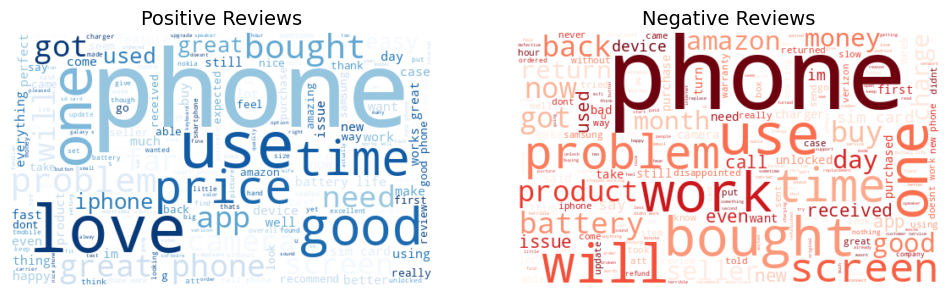

In [ ]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import pandas as pd

# Load the processed dataset
df = pd.read_csv('/content/drive/MyDrive/UnlockedMobile/labeled_dataset.csv')

# Ensure the 'label' column exists
if "label" not in df.columns:
    raise ValueError("The dataset must contain a 'label' column.")

# Ensure the 'processed_review' column exists
if "processed_review" not in df.columns:
    raise ValueError("The dataset must contain a 'processed_review' column.")

# Fill NaN values with an empty string and ensure all values are strings
df["processed_review"] = df["processed_review"].fillna("").astype(str)

# Separate positive and negative reviews
positive_reviews = " ".join(df[df["label"] == "positive"]["processed_review"])
negative_reviews = " ".join(df[df["label"] == "negative"]["processed_review"])

# Generate word clouds
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

wordcloud_pos = WordCloud(width=500, height=300, background_color="white", colormap="Blues").generate(positive_reviews)
ax[0].imshow(wordcloud_pos, interpolation="bilinear")
ax[0].set_title("Positive Reviews", fontsize=14)
ax[0].axis("off")

wordcloud_neg = WordCloud(width=500, height=300, background_color="white", colormap="Reds").generate(negative_reviews)
ax[1].imshow(wordcloud_neg, interpolation="bilinear")
ax[1].set_title("Negative Reviews", fontsize=14)
ax[1].axis("off")

plt.show()


In [ ]:
# Load the dataset
df = pd.read_csv('/content/drive/MyDrive/UnlockedMobile/Amazon_Unlocked_Mobile.csv')

# Total number of reviews
total_reviews = df.shape[0]
print(f"Total number of reviews: {total_reviews}")

# Calculate the number of reviews for training and testing
train_size = int(0.8 * total_reviews)  # 80% for training
test_size = total_reviews - train_size  # 20% for testing
print(f"Number of reviews for training: {train_size}")
print(f"Number of reviews for testing: {test_size}")

# Split the data into training and testing sets
train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)

In [ ]:
import pandas as pd

# Load Unlocked Mobiles Reviews dataset
mobiles_df = pd.read_csv("/content/drive/MyDrive/UnlockedMobile/Amazon_Unlocked_Mobile.csv")

# Calculate the number of words in each review
mobiles_df['review_length'] = mobiles_df['Reviews'].apply(lambda x: len(str(x).split()))

# Calculate statistics for Unlocked Mobiles Reviews
mobiles_summary = pd.DataFrame({
    "Metric": ["Total Reviews", "Unique Products", "Avg. Review Length (words)", "Std. Dev of Length"],
    "Unlocked Mobiles Reviews": [
        len(mobiles_df),
        mobiles_df['Product Name'].nunique(),  # Use ProductName instead of ProductId
        mobiles_df['review_length'].mean(),
        mobiles_df['review_length'].std()
    ]
})

# Display Unlocked Mobiles dataset statistics
display(mobiles_summary)


,Metric,Unlocked Mobiles Reviews
0,Total Reviews,413840.000000
1,Unique Products,4410.000000
2,Avg. Review Length (words),40.486222
3,Std. Dev of Length,85.230227


**1-Data Cleaning:** Clean the dataset by removing duplicates, irrelevant content, handling missing values and Lowercasing.

In [ ]:
# Load the dataset(400,000 mobile reviews)
file_path = "/content/drive/MyDrive/UnlockedMobile/Amazon_Unlocked_Mobile.csv"
df = pd.read_csv(file_path)

# Remove duplicates based on two column ('Reviews')
df = df.drop_duplicates(subset=['Reviews'])
print("\nDuplicates removed. Number of rows after removing duplicates:")
print(df.shape[0])

# Handle missing values by drop rows with missing 'Reviews'
df = df.dropna(subset=['Reviews', 'Rating'])
print("\nRows with missing 'Text' or 'Rating' removed. Number of rows after removal:")
print(df.shape[0])

# Remove HTML tags directly in the 'Reviews' column
df['Reviews'] = df['Reviews'].apply(lambda x: BeautifulSoup(x, "html.parser").get_text() if isinstance(x, str) and '<' in x and '>' in x else x)

# Remove promotional content
df['Reviews'] = df['Reviews'].apply(lambda x:re.sub(r'get \d+% off|use code|promo code', '', x))

# Remove URLs in the same column
df['Reviews'] = df['Reviews'].apply(lambda x: re.sub(r'http\S+|www\S+|https\S+', '', x))

 # Remove extra whitespace
df['Reviews'] = df['Reviews'].apply(lambda x:re.sub(r'\s+', ' ', x).strip())

# Lowercase the review text
df['Reviews'] = df['Reviews'].astype(str).str.lower()

# Save the cleaned dataset to a new CSV file
df.to_csv("/content/drive/MyDrive/UnlockedMobile/CleanedReviews.csv", index=False)
print("\nCleaned dataset saved successfully.")


Duplicates removed. Number of rows after removing duplicates:
162491

Rows with missing 'Text' or 'Rating' removed. Number of rows after removal:
162490

Cleaned dataset saved successfully.


**2- Preprocess Data:**Tokenization, Removing stop words, Stemming/Lemmatization and Removing special character

In [ ]:
import nltk
import spacy
import re
import pandas as pd
from nltk.sentiment import SentimentIntensityAnalyzer
from transformers import pipeline
from datasets import Dataset

# Download required NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('vader_lexicon')

# Load SpaCy model
nlp = spacy.load('en_core_web_sm')
spacy_stopwords = nlp.Defaults.stop_words

# Load sentiment analyzer (VADER for automatic negation detection)
sia = SentimentIntensityAnalyzer()

# Load sarcasm detection model (Using DeBERTa as a better alternative)
sarcasm_model = pipeline("text-classification", model="microsoft/deberta-v3-base")

# Function to handle negation using VADER
def handle_negation_vader(text):
    sentiment_score = sia.polarity_scores(text)
    if sentiment_score["neg"] > 0.5:  # If strong negative sentiment detected
        return "NOT_" + text  # Attach NOT_ prefix for emphasis
    return text

# Function to detect sarcasm
def detect_sarcasm(text):
    result = sarcasm_model(text)
    label = result[0]['label']

    if label.lower() == "sarcasm":
        return "SARCASM: " + text  # Tag sarcastic sentences
    return text

# Preprocessing function
def preprocess_review(text, use_lemmatization=True):
    if not isinstance(text, str):
        return ''

    # Remove special characters except punctuation
    text = re.sub(r'[^a-zA-Z\s.!?]', '', text)

    # Tokenization using SpaCy
    doc = nlp(text)
    tokens = [token.text for token in doc]

    # Remove stop words using SpaCy stopwords
    tokens = [word for word in tokens if word not in spacy_stopwords]

    # Lemmatization (if enabled)
    if use_lemmatization:
        tokens = [token.lemma_ for token in doc]

    # Apply automatic negation handling
    text = handle_negation_vader(text)

    # Detect sarcasm
    text = detect_sarcasm(text)

    return text

# Load dataset
df = pd.read_csv('/content/drive/MyDrive/UnlockedMobile/CleanedReviews.csv')

# Handle NaN values in 'Reviews' column
df['Reviews'] = df['Reviews'].fillna('')

# Apply preprocessing using datasets library
dataset = Dataset.from_pandas(df)
dataset = dataset.map(lambda x: {'processed_review': preprocess_review(x['Reviews'])})

# Convert back to pandas dataframe and save processed data
df_processed = dataset.to_pandas()

# Save processed data to CSV, keeping all columns
df_processed.to_csv('/content/drive/MyDrive/UnlockedMobile/PreprocessedReviews.csv', index=False)

print("✅ Preprocessing completed with automatic negation and sarcasm handling!")


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/371M [00:00<?, ?B/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/371M [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/convert_slow_tokenizer.py:561: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Device set to use cuda:0


Map:   0%|          | 0/162490 [00:00<?, ? examples/s]

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


✅ Preprocessing completed with automatic negation and sarcasm handling!


In [ ]:
#add label/sentiment column
df = pd.read_csv("/content/drive/MyDrive/UnlockedMobile/PreprocessedReviews.csv")

# Step 2: Create the 'label' column based on an existing 'Rating' column or using a model
# Example: Based on score column mapping
def map_score_to_label(score):
    if score <= 2:
        return 'negative'
    elif score == 3:
        return 'neutral'
    else:
        return 'positive'

# Apply function to create the label column
df['label'] = df['Rating'].apply(map_score_to_label)

# Step 3: Save the updated DataFrame back to a new CSV file
df.to_csv("/content/drive/MyDrive/UnlockedMobile/labeled_dataset.csv", index=False)  # Save without row indices


label
positive    103773
negative     44351
neutral      14366
Name: count, dtype: int64


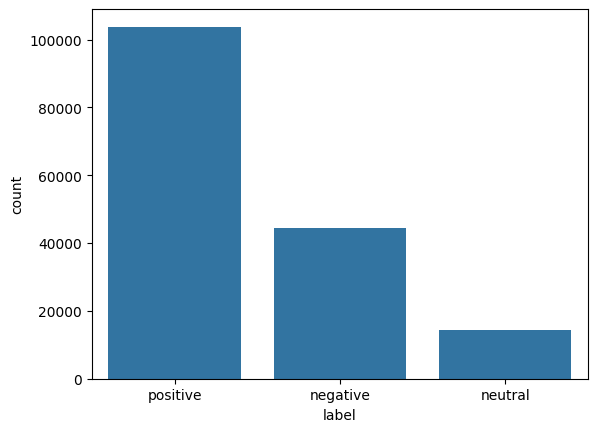

In [ ]:
# ensure the dataset is correctly labeled for sentiment (positive, negative, neutral)
df = pd.read_csv("/content/drive/MyDrive/UnlockedMobile/labeled_dataset.csv")

# Assuming your labels are in the 'label' column
label_counts = df['label'].value_counts()
print(label_counts)

# Visualize distribution
sns.countplot(data=df, x='label')
plt.show()

**3- Feature Extraction and Machine Learning Models:** Feature Extraction to Convert text data into numerical data using TF-IDF. ML models:Logistic Regression ,Naive Bayes, Support Vector Machines (SVM), Random Forest and Gradient Boosting Machines (GBM)

In [ ]:
# Machine Learning

df = pd.read_csv('/content/drive/MyDrive/UnlockedMobile/labeled_dataset.csv')

# Retain only the required columns for processing
df = df[['Reviews', 'label']]

# Remove rows with NaN values in the 'Reviews' column
df = df.dropna(subset=['Reviews'])

# Balance the dataset using oversampling
rus = RandomOverSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(df[['Reviews']], df['label'])

# Combine back into a balanced DataFrame
balanced_df = pd.DataFrame({'Reviews': X_resampled['Reviews'], 'label': y_resampled})

# Define X and y
X = balanced_df['Reviews']
y = balanced_df['label']

# Encode labels for multiclass classification
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(y)

# Split dataset
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Transform text data using TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(max_features=100000, ngram_range=(1, 2))
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# Evaluation function
def evaluate_model(y_true, y_pred, y_proba=None, average='binary'):
    precision = precision_score(y_true, y_pred, average=average)
    recall = recall_score(y_true, y_pred, average=average)
    f1 = f1_score(y_true, y_pred, average=average)
    accuracy = accuracy_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_proba, multi_class='ovr') if y_proba is not None else 'N/A'

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC AUC: {roc_auc if roc_auc != 'N/A' else 'N/A'}\n")
    # Compute and plot confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()



Random Forest:
Accuracy: 0.9360
Precision: 0.9365
Recall: 0.9359
F1 Score: 0.9361
ROC AUC: 0.988437248760361



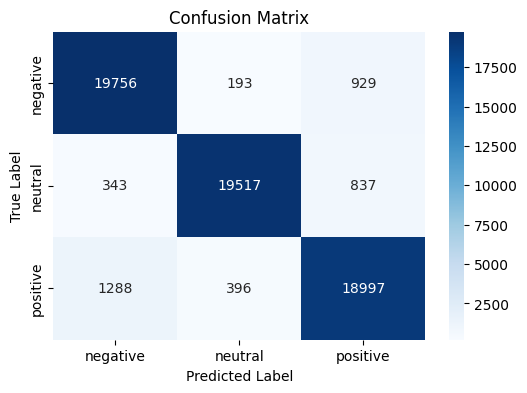

In [ ]:
# Train and evaluate Random Forest
print("\nRandom Forest:")
rf = RandomForestClassifier(min_samples_split=5,min_samples_leaf=2)
rf.fit(X_train_tfidf, y_train)
y_pred_rf = rf.predict(X_test_tfidf)
y_proba_rf = rf.predict_proba(X_test_tfidf)[:, 1] if len(le.classes_) == 2 else rf.predict_proba(X_test_tfidf)
evaluate_model(y_test, y_pred_rf, y_proba_rf if len(le.classes_) == 2 else y_proba_rf, average='macro' if len(le.classes_) > 2 else 'binary')


Logistic Regression:
Accuracy: 0.8930
Precision: 0.8953
Recall: 0.8930
F1 Score: 0.8934
ROC AUC: 0.9704851237617271



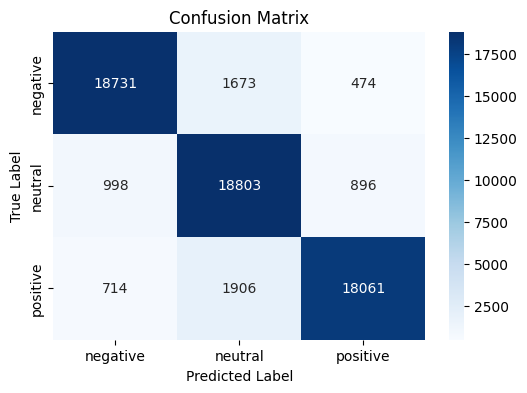


Naive Bayes:
Accuracy: 0.8104
Precision: 0.8106
Recall: 0.8103
F1 Score: 0.8103
ROC AUC: 0.9358624463167237



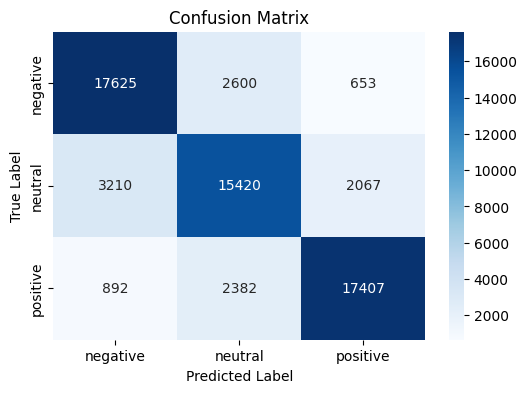

In [ ]:
#Machine Learning
# Train and evaluate Logistic Regression
print("\nLogistic Regression:")
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train_tfidf, y_train)
y_pred_lr = log_reg.predict(X_test_tfidf)
y_proba_lr = log_reg.predict_proba(X_test_tfidf)[:, 1] if len(le.classes_) == 2 else log_reg.predict_proba(X_test_tfidf)
evaluate_model(y_test, y_pred_lr, y_proba_lr if len(le.classes_) == 2 else y_proba_lr, average='macro' if len(le.classes_) > 2 else 'binary')

# Train and evaluate Naive Bayes
print("\nNaive Bayes:")
nb = MultinomialNB()
nb.fit(X_train_tfidf, y_train)
y_pred_nb = nb.predict(X_test_tfidf)
y_proba_nb = nb.predict_proba(X_test_tfidf)[:, 1] if len(le.classes_) == 2 else nb.predict_proba(X_test_tfidf)
evaluate_model(y_test, y_pred_nb, y_proba_nb if len(le.classes_) == 2 else y_proba_nb, average='macro' if len(le.classes_) > 2 else 'binary')


Gradient Boosting Machine:
Accuracy: 0.6816
Precision: 0.6789
Recall: 0.6815
F1 Score: 0.6795
ROC AUC: 0.8504608828462447



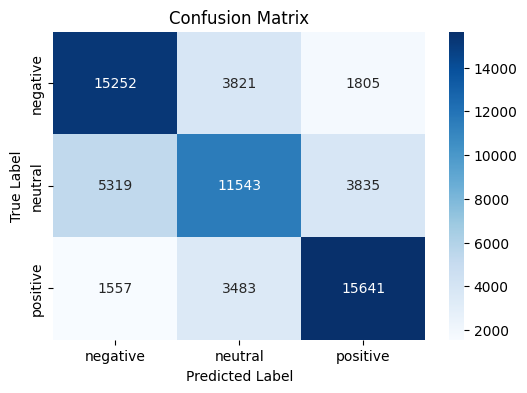

In [ ]:
# Train and evaluate Gradient Boosting Machines (GBM)
print("\nGradient Boosting Machine:")
gbm = GradientBoostingClassifier(min_samples_split=5,min_samples_leaf=2)
gbm.fit(X_train_tfidf, y_train)
y_pred_gbm = gbm.predict(X_test_tfidf)
y_proba_gbm = gbm.predict_proba(X_test_tfidf)[:, 1] if len(le.classes_) == 2 else gbm.predict_proba(X_test_tfidf)
evaluate_model(y_test, y_pred_gbm, y_proba_gbm if len(le.classes_) == 2 else y_proba_gbm, average='macro' if len(le.classes_) > 2 else 'binary')


Support Vector Machine:
Accuracy: 0.9362
Precision: 0.9365
Recall: 0.9362
F1 Score: 0.9361
ROC AUC: 0.984686604833099



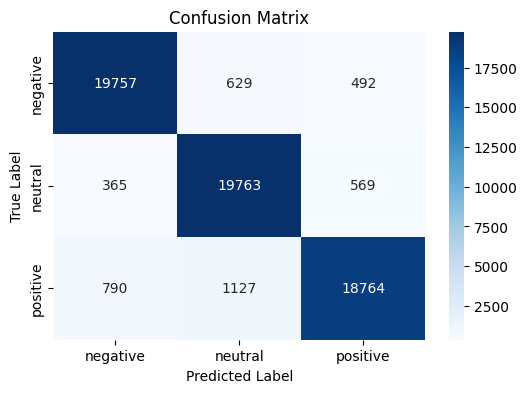

In [ ]:
# Train and evaluate Support Vector Machines (SVM)
print("\nSupport Vector Machine:")
svc = LinearSVC()
svm = CalibratedClassifierCV(svc, cv=5)
# Train the calibrated model
svm.fit(X_train_tfidf, y_train)
# Get probability predictions on the test set
svm_pred_proba = svm.predict_proba(X_test_tfidf)[:, 1] if len(le.classes_) == 2 else svm.predict_proba(X_test_tfidf)
y_pred = svm.predict(X_test_tfidf)
evaluate_model(y_test, y_pred, svm_pred_proba if len(le.classes_) == 2 else svm_pred_proba, average='macro' if len(le.classes_) > 2 else 'binary')

**5- Deep Learning :**Train and evaluate deep learning models:Long Short Term Memory(LSTM),Convolutional Neural Networks (CNNs) and Roberta

In [ ]:
# Load the dataset
df = pd.read_csv('/content/drive/MyDrive/UnlockedMobile/labeled_dataset.csv')
X = df['Reviews']
y = df['label']

# Balance the dataset using oversampling
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(df[['Reviews']], df['label'])

# Combine back into a balanced DataFrame
balanced_df = pd.DataFrame({'Reviews': X_resampled['Reviews'], 'label': y_resampled})

# Define X and y
X = balanced_df['Reviews']
y = balanced_df['label']

# Encode labels
lb = LabelBinarizer()
y = lb.fit_transform(y)
if y.shape[1] == 1:  # For binary labels
    y = y.ravel()

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Check for NaN values and replace with an empty string
X_train = X_train.fillna('')
X_test = X_test.fillna('')

# Ensure all values are strings
X_train = X_train.astype(str)
X_test = X_test.astype(str)

# Tokenize for deep learning models
max_words = 10000
max_len = 200
tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_padded = pad_sequences(X_train_seq, maxlen=max_len, padding='post', truncating='post')
X_test_padded = pad_sequences(X_test_seq, maxlen=max_len, padding='post', truncating='post')

# Define CNN model
def build_cnn_model():
    model = Sequential([
        Embedding(input_dim=10000, output_dim=128, input_length=200),
        Conv1D(64, kernel_size=3, activation='relu'),
        GlobalMaxPooling1D(),
        Dense(3, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Define LSTM model
def build_lstm_model():
    model = Sequential([
        Embedding(input_dim=10000, output_dim=128, input_length=200),
        LSTM(128, return_sequences=False),
        Dense(3, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Define evaluation function for multiclass classification
def evaluate_model(model, X_test, y_test, model_name="Model"):
    # Get predicted probabilities
    y_pred_proba = model.predict(X_test)

    # Convert probabilities to class labels (argmax for multiclass)
    y_pred = np.argmax(y_pred_proba, axis=1)

    # Convert y_test to integers if it's one-hot encoded
    if len(y_test.shape) > 1 and y_test.shape[1] > 1:
        y_test = np.argmax(y_test, axis=1)

    # Calculate metrics
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')
    accuracy = accuracy_score(y_test, y_pred)

    # Calculate Multi-class ROC AUC (One-vs-Rest approach)
    try:
        roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='macro')
    except ValueError:
        roc_auc = None

    # Print results
    print(f"{model_name} - Accuracy: {accuracy:.4f}")
    print(f"{model_name} - Precision (Macro): {precision:.4f}")
    print(f"{model_name} - Recall (Macro): {recall:.4f}")
    print(f"{model_name} - F1 Score (Macro): {f1:.4f}")
    if roc_auc is not None:
        print(f"{model_name} - ROC AUC (Macro): {roc_auc:.4f}")
    else:
        print(f"{model_name} - ROC AUC could not be calculated.")
    # Compute and plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()


Training CNN Model...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/5
7783/7783 ━━━━━━━━━━━━━━━━━━━━ 103s 13ms/step - accuracy: 0.7349 - loss: 0.6238 - val_accuracy: 0.8671 - val_loss: 0.3713
Epoch 2/5
7783/7783 ━━━━━━━━━━━━━━━━━━━━ 102s 13ms/step - accuracy: 0.9084 - loss: 0.2741 - val_accuracy: 0.9172 - val_loss: 0.2529
Epoch 3/5
7783/7783 ━━━━━━━━━━━━━━━━━━━━ 102s 13ms/step - accuracy: 0.9548 - loss: 0.1440 - val_accuracy: 0.9329 - val_loss: 0.2166
Epoch 4/5
7783/7783 ━━━━━━━━━━━━━━━━━━━━ 102s 13ms/step - accuracy: 0.9719 - loss: 0.0891 - val_accuracy: 0.9420 - val_loss: 0.2142
Epoch 5/5
7783/7783 ━━━━━━━━━━━━━━━━━━━━ 102s 13ms/step - accuracy: 0.9804 - loss: 0.0627 - val_accuracy: 0.9465 - val_loss: 0.2130
1946/1946 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step
CNN - Accuracy: 0.9465
CNN - Precision (Macro): 0.9468
CNN - Recall (Macro): 0.9464
CNN - F1 Score (Macro): 0.9462
CNN - ROC AUC (Macro): 0.9887


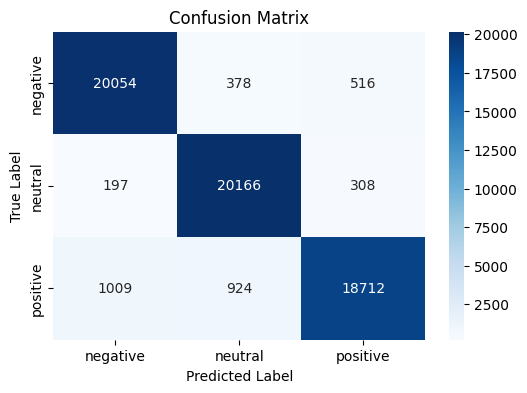

In [ ]:
# Train and evaluate the CNN model
print("\nTraining CNN Model...")
cnn_model = build_cnn_model()
cnn_model.fit(X_train_padded, y_train, validation_data=(X_test_padded, y_test), epochs=5, batch_size=32)
evaluate_model(cnn_model, X_test_padded, y_test, model_name="CNN")

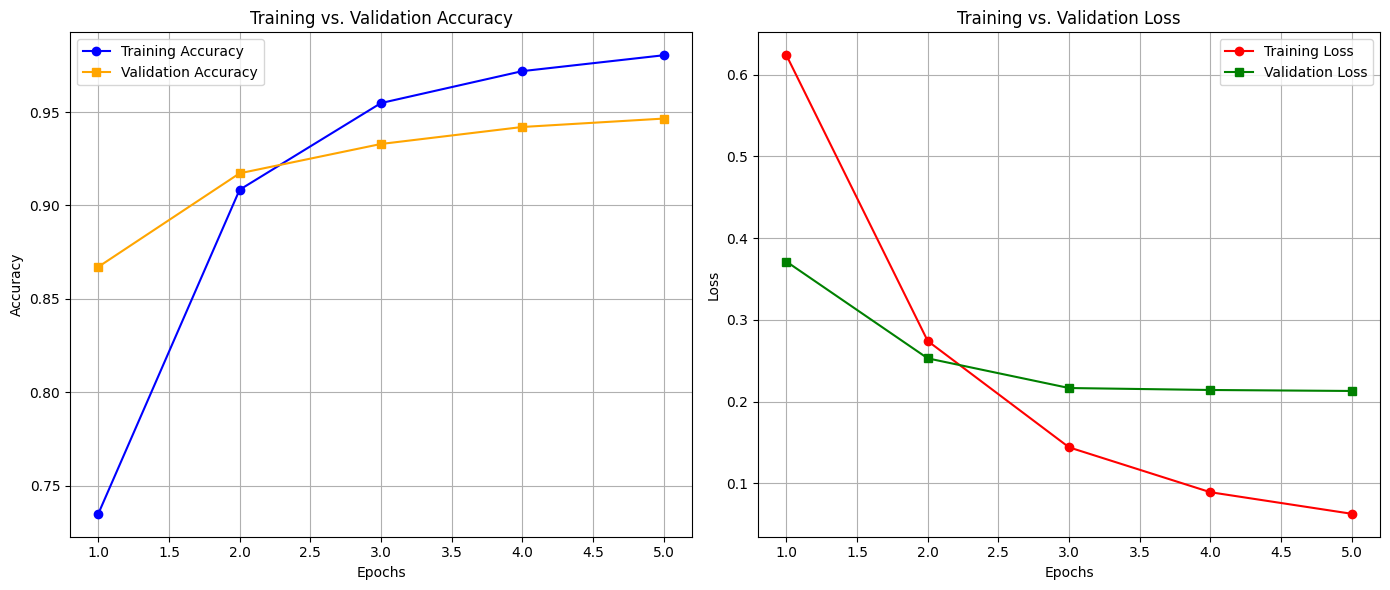

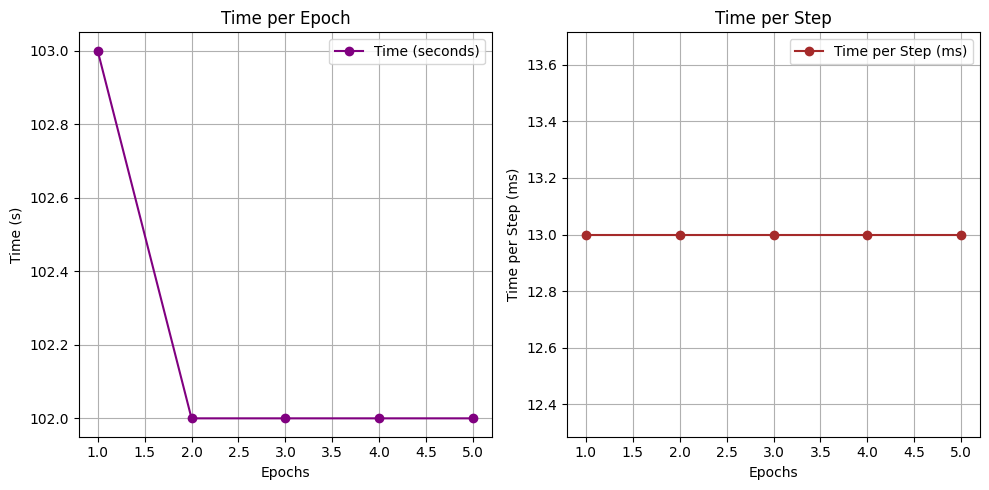

In [ ]:
import matplotlib.pyplot as plt

# Data from the table
epochs = [1, 2, 3, 4, 5]
accuracy = [0.7349, 0.9084, 0.9548, 0.9719, 0.9804]
val_accuracy = [0.8671, 0.9172, 0.9329, 0.9420, 0.9465]
loss = [0.6238, 0.2741, 0.1440, 0.0891, 0.0627]
val_loss = [0.3713, 0.2529, 0.2166, 0.2142, 0.2130]
time_in_seconds = [103, 102, 102, 102, 102]
time_per_step = [13, 13, 13, 13, 13]

# Plot Accuracy
plt.figure(figsize=(14, 6))

# Accuracy subplot
plt.subplot(1, 2, 1)
plt.plot(epochs, accuracy, 'o-', label="Training Accuracy", color='blue')
plt.plot(epochs, val_accuracy, 's-', label="Validation Accuracy", color='orange')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training vs. Validation Accuracy")
plt.legend()
plt.grid()

# Loss subplot
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'o-', label="Training Loss", color='red')
plt.plot(epochs, val_loss, 's-', label="Validation Loss", color='green')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs. Validation Loss")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

# Plot Time (in seconds) and Time per Step (in ms)
plt.figure(figsize=(10, 5))

# Plot Time in Seconds
plt.subplot(1, 2, 1)
plt.plot(epochs, time_in_seconds, 'o-', label="Time (seconds)", color='purple')
plt.xlabel("Epochs")
plt.ylabel("Time (s)")
plt.title("Time per Epoch")
plt.legend()
plt.grid()

# Plot Time per Step (in ms)
plt.subplot(1, 2, 2)
plt.plot(epochs, time_per_step, 'o-', label="Time per Step (ms)", color='brown')
plt.xlabel("Epochs")
plt.ylabel("Time per Step (ms)")
plt.title("Time per Step")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()



Training LSTM Model...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/5
7783/7783 ━━━━━━━━━━━━━━━━━━━━ 1265s 162ms/step - accuracy: 0.3374 - loss: 1.0952 - val_accuracy: 0.3461 - val_loss: 1.0832
Epoch 2/5
7783/7783 ━━━━━━━━━━━━━━━━━━━━ 1268s 163ms/step - accuracy: 0.3544 - loss: 1.0697 - val_accuracy: 0.3913 - val_loss: 1.0510
Epoch 3/5
7783/7783 ━━━━━━━━━━━━━━━━━━━━ 1274s 164ms/step - accuracy: 0.4740 - loss: 0.9585 - val_accuracy: 0.7826 - val_loss: 0.5448
Epoch 4/5
7783/7783 ━━━━━━━━━━━━━━━━━━━━ 1281s 165ms/step - accuracy: 0.8147 - loss: 0.4846 - val_accuracy: 0.8434 - val_loss: 0.4384
Epoch 5/5
7783/7783 ━━━━━━━━━━━━━━━━━━━━ 1283s 165ms/step - accuracy: 0.8807 - loss: 0.3498 - val_accuracy: 0.8776 - val_loss: 0.3645
1946/1946 ━━━━━━━━━━━━━━━━━━━━ 113s 58ms/step
LSTM - Accuracy: 0.8776
LSTM - Precision (Macro): 0.8788
LSTM - Recall (Macro): 0.8775
LSTM - F1 Score (Macro): 0.8778
LSTM - ROC AUC (Macro): 0.9612


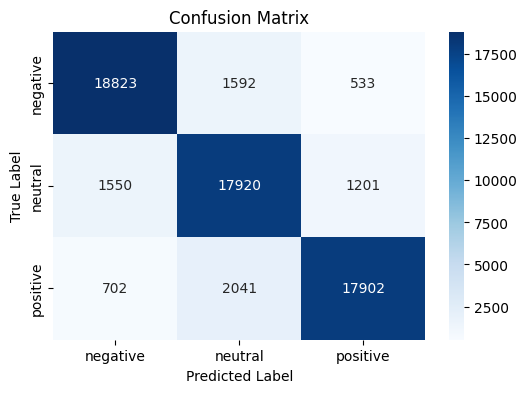

In [ ]:
# Train and evaluate the LSTM model
print("\nTraining LSTM Model...")
lstm_model = build_lstm_model()
lstm_model.fit(X_train_padded, y_train, validation_data=(X_test_padded, y_test), epochs=5, batch_size=32)
evaluate_model(lstm_model, X_test_padded, y_test, model_name="LSTM")

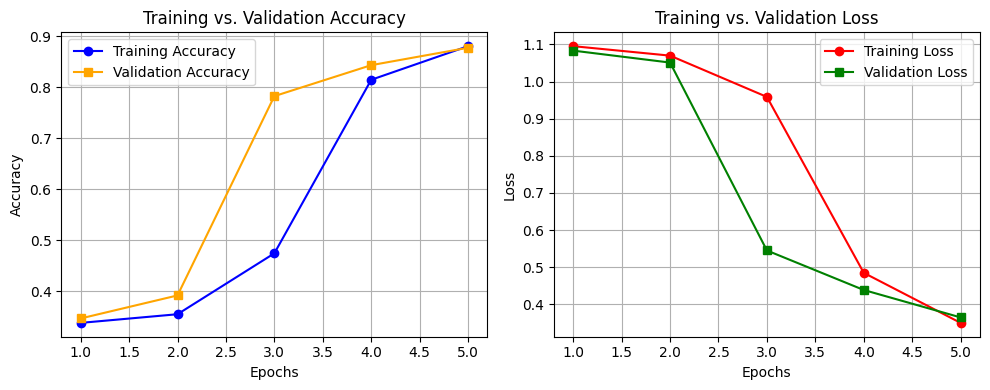

In [ ]:
import matplotlib.pyplot as plt

# Data from the table
epochs = [1, 2, 3, 4, 5]
accuracy = [0.3374, 0.3544, 0.4740, 0.8147, 0.8807]
val_accuracy = [0.3461, 0.3913, 0.7826, 0.8434, 0.8776]
loss = [1.0952, 1.0697, 0.9585, 0.4846, 0.3498]
val_loss = [1.0832, 1.0510, 0.5448, 0.4384, 0.3645]

# Plot Accuracy
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, accuracy, 'o-', label="Training Accuracy", color='blue')
plt.plot(epochs, val_accuracy, 's-', label="Validation Accuracy", color='orange')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training vs. Validation Accuracy")
plt.legend()
plt.grid()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'o-', label="Training Loss", color='red')
plt.plot(epochs, val_loss, 's-', label="Validation Loss", color='green')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs. Validation Loss")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-5-3da3e07167d7>:126: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Roc Auc
1,0.466800,0.349534,0.879562,0.889607,0.879653,0.881137,N/A
2,0.198600,0.329086,0.911655,0.922468,0.911725,0.912747,N/A
3,0.293200,0.254245,0.942961,0.945926,0.942977,0.943141,N/A


{'accuracy': 0.8795618093035209, 'precision': 0.8896068313474285, 'recall': 0.8796528222659417, 'f1': 0.8811371188364315, 'roc_auc': 'N/A'}
{'accuracy': 0.9116551015163197, 'precision': 0.9224675784210484, 'recall': 0.9117247204153002, 'f1': 0.9127471313774219, 'roc_auc': 'N/A'}
{'accuracy': 0.942961320997173, 'precision': 0.9459259918121209, 'recall': 0.9429773354728472, 'f1': 0.9431413912251156, 'roc_auc': 'N/A'}


{'accuracy': 0.942961320997173, 'precision': 0.9459259918121209, 'recall': 0.9429773354728472, 'f1': 0.9431413912251156, 'roc_auc': 'N/A'}
Evaluation Results: {'eval_loss': 0.2542448937892914, 'eval_accuracy': 0.942961320997173, 'eval_precision': 0.9459259918121209, 'eval_recall': 0.9429773354728472, 'eval_f1': 0.9431413912251156, 'eval_roc_auc': 'N/A', 'eval_runtime': 108.8707, 'eval_samples_per_second': 571.834, 'eval_steps_per_second': 35.74, 'epoch': 3.0}
{'accuracy': 0.942961320997173, 'precision': 0.9459259918121209, 'recall': 0.9429773354728472, 'f1': 0.9431413912251156, 'roc_auc': 'N/A'}


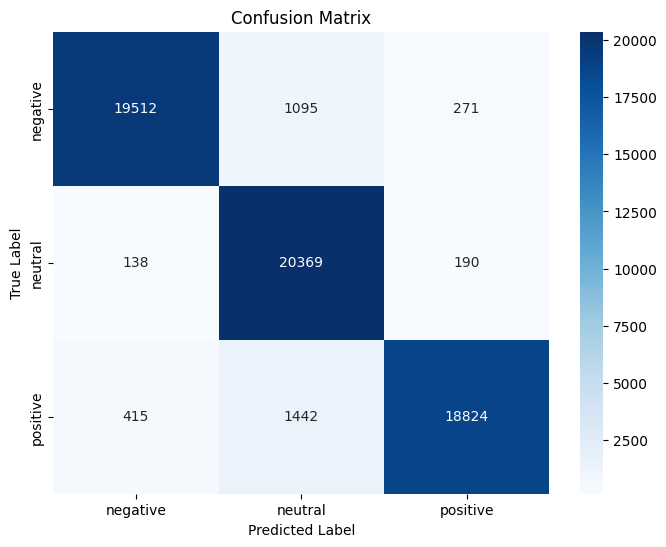

In [ ]:
import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import RobertaTokenizer, RobertaForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import Dataset
from imblearn.under_sampling import RandomUnderSampler

# Load dataset
df = pd.read_csv('/content/drive/MyDrive/UnlockedMobile/labeled_dataset.csv')  # Replace with the actual file path
df = df[['Reviews', 'label']].dropna()

# Encode labels
le = LabelEncoder()
df['label'] = le.fit_transform(df['label'])

# Split data into text and labels
texts = df['Reviews'].tolist()
labels = np.array(df['label'])  # Convert labels to NumPy array

# Tokenization
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

# Tokenize the entire dataset first
encoded_inputs = tokenizer(
    texts,
    max_length=128,
    truncation=True,
    padding="max_length",
    return_tensors="np",
)
input_ids = encoded_inputs['input_ids']
attention_masks = encoded_inputs['attention_mask']

# Balance the dataset using oversampling
rus = RandomOverSampler(random_state=42)
input_ids_resampled, labels_resampled = rus.fit_resample(input_ids, labels)
attention_masks_resampled, _ = rus.fit_resample(attention_masks, labels)

# Get indices of resampled data to filter texts
indices_resampled = rus.sample_indices_
texts_resampled = [texts[i] for i in indices_resampled]  # Get the corresponding resampled texts

# Combine back into a balanced DataFrame
balanced_df = pd.DataFrame({'processed_review': texts_resampled, 'label': labels_resampled})

# Train-test split
X_train_ids, X_test_ids, X_train_masks, X_test_masks, y_train, y_test = train_test_split(
    input_ids_resampled,
    attention_masks_resampled,
    labels_resampled,
    test_size=0.2,
    random_state=42,
)

# Custom Dataset Class
class SentimentDataset(Dataset):
    def __init__(self, input_ids, attention_masks, labels):
        self.input_ids = input_ids
        self.attention_masks = attention_masks
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            "input_ids": torch.tensor(self.input_ids[idx], dtype=torch.long),
            "attention_mask": torch.tensor(self.attention_masks[idx], dtype=torch.long),
            "label": torch.tensor(self.labels[idx], dtype=torch.long),
        }

# Create datasets
train_dataset = SentimentDataset(X_train_ids, X_train_masks, y_train)
val_dataset = SentimentDataset(X_test_ids, X_test_masks, y_test)

# Roberta Model
model = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=len(le.classes_))

# Metrics
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    pred_proba = pred.predictions  # probabilities for each class

    acc = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="macro")

    # Compute ROC-AUC score for multi-class
    try:
        roc_auc = roc_auc_score(labels, pred_proba, multi_class="ovr", average="macro", labels=np.unique(labels))
    except ValueError:
        roc_auc = "N/A"  # Handle edge cases (e.g., single class in test set)

    metrics = {
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "roc_auc": roc_auc if roc_auc != "N/A" else "N/A",
    }
    print(metrics)
    return metrics

# Training arguments
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    load_best_model_at_end=True,
    report_to="none",
)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

# Train the model
trainer.train()

# Evaluate the model
eval_results = trainer.evaluate()
print(f"Evaluation Results: {eval_results}")

# Save the model and tokenizer
model.save_pretrained("./roberta_sentiment")
tokenizer.save_pretrained("./roberta_sentiment")

# Generate Confusion Matrix
predictions = trainer.predict(val_dataset)  # Get predictions
preds = np.argmax(predictions.predictions, axis=-1)  # Get predicted class indices
y_true = predictions.label_ids  # Get true labels

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, preds)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


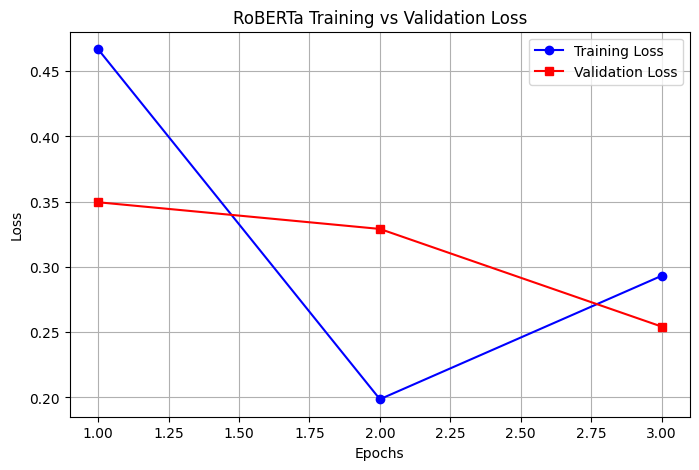

In [ ]:
import matplotlib.pyplot as plt

# Epochs
epochs = [1, 2, 3]

# Updated Training and Validation Loss values
training_loss = [0.4668, 0.1986, 0.2932]
validation_loss = [0.349534, 0.329086, 0.254245]

# Plot
plt.figure(figsize=(8, 5))
plt.plot(epochs, training_loss, marker="o", linestyle="-", color="blue", label="Training Loss")
plt.plot(epochs, validation_loss, marker="s", linestyle="-", color="red", label="Validation Loss")

# Labels and Title
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("RoBERTa Training vs Validation Loss")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()
